# ENGS106 Final Project: Deep Learning Pipeline for Optiver Data

This notebook includes a deep learning pipeline using a GRU-based model for the Optiver
closing auction dataset.

The Optiver dataset consists of historic data for the NASDAQ ten-minute closing auction.
It is used to predict future price movements relative to a synthetic index.
The split for cross validation is done between dates (there are 5,237,760 rows overall).


## Todo

- Fix comments
- Try new preprocessing
- 5.94 MAE, -0.0003 R^2
- Feature elimination

## Import Libraries, Set Parameters, Read & Display Data

In [1]:
# Cell 1: Revised Imports, Seed, Hyperparameters & CV Splitter Definition
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler  # Still using MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW  # Using AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Revised Hyperparameters
BATCH_SIZE = 32           # Smaller batch size for more frequent updates
NUM_EPOCHS = 300          # Increase epochs for longer training
LEARNING_RATE = 1e-3      # Lower learning rate for more stable convergence
WEIGHT_DECAY = 1e-3       # Slightly reduced weight decay
DROPOUT = 0.1             # Reduced dropout to allow more capacity
PATIENCE = 10             # Increased patience for early stopping
LR_PATIENCE = 5
N_FOLDS = 5               # Number of CV folds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pd.set_option('display.max_columns', None)

# -------------------------------------------------------------
# PurgedGroupTimeSeriesSplit (same as before)
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *,
                 max_train_group_size=np.inf,
                 max_val_group_size=np.inf,
                 val_group_gap=10,
                 verbose=False):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.max_val_group_size = max_val_group_size
        self.val_group_gap = val_group_gap
        self.verbose = verbose
        
    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_splits = self.n_splits
        group_gap = self.val_group_gap
        max_val_group_size = self.max_val_group_size
        n_folds = n_splits + 1
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_groups = _num_samples(unique_groups)
        if n_folds > n_groups:
            raise ValueError("Number of folds={} cannot be greater than number of groups={}".format(n_folds, n_groups))
        group_val_size = min(n_groups // n_folds, max_val_group_size)
        group_val_starts = range(n_groups - n_splits * group_val_size, n_groups, group_val_size)
        group_dict = {}
        n_samples = _num_samples(X)
        for idx in range(n_samples):
            group = groups[idx]
            group_dict.setdefault(group, []).append(idx)
        for group_val_start in group_val_starts:
            train_indices = []
            val_indices = []
            # training groups: all groups before the validation gap
            for g in unique_groups[:max(0, group_val_start - group_gap)]:
                train_indices.extend(group_dict[g])
            # validation groups: the next group_val_size groups
            for g in unique_groups[group_val_start:group_val_start + group_val_size]:
                val_indices.extend(group_dict[g])
            yield train_indices, val_indices


In [2]:
def load_df_from_zip(zip_filename, csv_filename):
    try:
        with zipfile.ZipFile(zip_filename, 'r') as zf:
            with zf.open(csv_filename) as csvfile:
                return pd.read_csv(csvfile)
    except Exception as e:
        print(f"Error loading {csv_filename} from {zip_filename}: {e}")
        return None

# Load part 1 (other parts can be similarly loaded and concatenated)
df_part_1 = load_df_from_zip("data_features_part_1.zip", "data_features_part_1.csv")
# Uncomment the following if additional parts are available
# df_part_2 = load_df_from_zip("data_features_part_2.zip", "data_features_part_2.csv")
# df_part_3 = load_df_from_zip("data_features_part_3.zip", "data_features_part_3.csv")
# df_part_4 = load_df_from_zip("data_features_part_4.zip", "data_features_part_4.csv")

# Concatenate all parts into a single DataFrame
# df = pd.concat([df_part_1, df_part_2, df_part_3, df_part_4], ignore_index=True)
df = df_part_1

display(df.head(), df.shape, df['target'].head())


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,baseline_prediction,simple_prediction,seconds_in_bucket_group,imbalance_buy_flag,imbalance_sell_flag,no_imbalance,bid_plus_ask_sizes,median_vol,high_volume,imbalance_ratio,bid_ask_volume_diff,mid_price,size_imbalance,price_spread,liquidity_imbalance,matched_imbalance,market_urgency,market_urgency_v2,far_price_reference_price_imb,near_price_reference_price_imb,near_price_far_price_imb,bid_price_reference_price_imb,bid_price_far_price_imb,bid_price_near_price_imb,ask_price_reference_price_imb,ask_price_far_price_imb,ask_price_near_price_imb,ask_price_bid_price_imb,wap_reference_price_imb,wap_far_price_imb,wap_near_price_imb,wap_bid_price_imb,wap_ask_price_imb,near_price_far_price_reference_price_imb2,bid_price_far_price_reference_price_imb2,bid_price_near_price_reference_price_imb2,bid_price_near_price_far_price_imb2,ask_price_far_price_reference_price_imb2,ask_price_near_price_reference_price_imb2,ask_price_near_price_far_price_imb2,ask_price_bid_price_reference_price_imb2,ask_price_bid_price_far_price_imb2,ask_price_bid_price_near_price_imb2,wap_far_price_reference_price_imb2,wap_near_price_reference_price_imb2,wap_near_price_far_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_ask_price_reference_price_imb2,wap_ask_price_far_price_imb2,wap_ask_price_near_price_imb2,wap_ask_price_bid_price_imb2,stock_weights,weighted_wap,wap_momentum,imbalance_momentum,spread_intensity,price_pressure,depth_pressure,spread_depth_ratio,mid_price_movement,micro_price,relative_spread,all_prices_mean,all_sizes_mean,all_prices_std,all_sizes_std,all_prices_skew,all_sizes_skew,all_prices_kurt,all_sizes_kurt,vwap,rolling_mean_matched_size,wap_skewness,wap_kurtosis,is_high_volume,matched_size_group_first_ratio,ask_price_group_first_ratio,bid_price_group_first_ratio,ask_size_group_first_ratio,bid_size_group_first_ratio,wap_group_first_ratio,near_price_group_first_ratio,far_price_group_first_ratio,reference_price_group_first_ratio,matched_size_group_expanding_mean100,ask_price_group_expanding_mean100,bid_price_group_expanding_mean100,ask_size_group_expanding_mean100,bid_size_group_expanding_mean100,wap_group_expanding_mean100,near_price_group_expanding_mean100,far_price_group_expanding_mean100,reference_price_group_expanding_mean100,matched_size_seconds_in_bucket_group_mean_ratio,ask_price_seconds_in_bucket_group_mean_ratio,bid_price_seconds_in_bucket_group_mean_ratio,ask_size_seconds_in_bucket_group_mean_ratio,bid_size_seconds_in_bucket_group_mean_ratio,wap_seconds_in_bucket_group_mean_ratio,near_price_seconds_in_bucket_group_mean_ratio,far_price_seconds_in_bucket_group_mean_ratio,reference_price_seconds_in_bucket_group_mean_ratio,matched_size_seconds_in_bucket_group_rank,ask_price_seconds_in_bucket_group_rank,bid_price_seconds_in_bucket_group_rank,ask_size_seconds_in_bucket_group_rank,bid_size_seconds_in_bucket_group_rank,wap_seconds_in_bucket_group_rank,near_price_seconds_in_bucket_group_rank,far_price_seconds_in_bucket_group_rank,reference_price_seconds_in_bucket_group_rank
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.001713,0.99966,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0,0,0.1,0.0,1,0,0,69144.53,42739.16,1,0.237708,-52158.47,0.999919,7.141326,0.000214,0.754340,-0.615890,0.000161,0.000081,0.000950,-0.000076,-0.001026,0.000000,-0.000950,0.000076,0.000107,-0.000843,0.000183,0.000107,0.000094,-0.000856,0.00017,9.400884e-05,-0.000013,12.514451,1.712151e+13,0.000000,12.514451,7.882566,1.408878,4.610268,-1.927541e+12,7.882566,1.408878,9.111006,1.237706,5.039422,-1.693354e+12,9.111006,1.237706,0.138298,64.879580,0.076494,0.138298,0.004,0.004,0.0,0.0,0.0,680.648976,-107.068979,3.094966e-09,0,1.000000,0.000214,1.000170,4.157506e+06,0.000768,6.324881e+06,2.278791,1.695159,5.364051,2.775961,0.999618,13

(1309440, 130)

0   -3.029704
1   -5.519986
2   -8.389950
3   -4.010200
4   -7.349849
Name: target, dtype: float64

In [3]:
# ## How to read the training data now
# file_path = "optiver_training_data/train_part_1.csv.zip"
# df_1 = pd.read_csv(file_path, compression='zip')

# file_path = "optiver_training_data/train_part_2.csv.zip"
# df_2 = pd.read_csv(file_path, compression='zip')

# file_path = "optiver_training_data/train_part_3.csv.zip"
# df_3 = pd.read_csv(file_path, compression='zip')

# df = pd.concat([df_1, df_2, df_3], ignore_index=True)
# df.head()

## Data Preparation

This code prepares time-series data for model training by performing a temporal split based on `date_id`, dividing the dataset into training (70%), validation (15%), and test (15%) sets. It selects features, separates the target variable, and optionally applies feature scaling (commented out). The processed data is converted into DataFrames, excluding `date_id` for training. Finally, it creates PyTorch `SequenceDataset` objects and corresponding DataLoaders for efficient batch processing during model training and validation.

In [4]:
# Specify identifier columns and target; assume the rest need scaling
id_cols = ['date_id', 'time_id', 'stock_id']
scale_cols = [col for col in df.columns if col not in id_cols + ['target']]

# Instead of a fixed 70/15/15 split, we’ll use time-series CV.
# Fit the scaler on the entire dataset or (preferably) on training folds only.
scaler = MinMaxScaler().fit(df[scale_cols])
def scale_data(df, scaler, scale_cols, id_cols):
    scaled = scaler.transform(df[scale_cols])
    scaled_df = pd.DataFrame(scaled, columns=scale_cols, index=df.index)
    for col in id_cols + ['target']:
        scaled_df[col] = df[col].values
    return scaled_df

df = scale_data(df, scaler, scale_cols, id_cols)

# We use 'time_id' as our group label for CV.
groups = df['time_id'].values

# Initialize our CV splitter
cv = PurgedGroupTimeSeriesSplit(n_splits=N_FOLDS, max_val_group_size=200, val_group_gap=10)


In [5]:
# Cell 4: Revised Dataset and CNN Model Architecture with BatchNorm

class StockDataset(Dataset):
    def __init__(self, df, scale_cols, id_cols):
        self.scale_cols = scale_cols
        self.id_cols = id_cols
        # Group by time_id so that each sample is one time slice
        self.groups = [group for _, group in df.groupby('time_id')]
        
    def __len__(self):
        return len(self.groups)
    
    def __getitem__(self, idx):
        group = self.groups[idx].copy()
        # Ensure consistent ordering by stock_id
        group = group.sort_values('stock_id')
        # Pad to 200 stocks if necessary
        group = group.set_index('stock_id').reindex(range(200), fill_value=0).reset_index()
        # Use only scaled features for the model
        features_tensor = torch.tensor(group[self.scale_cols].values, dtype=torch.float32)
        targets_tensor = torch.tensor(group['target'].values, dtype=torch.float32)
        # Transpose: shape becomes (num_features, 200)
        return features_tensor.T, targets_tensor

# Revised CNN Model Architecture with Batch Normalization
class CNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AvgPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AvgPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool1d(1)  # Global average pooling to produce (batch, 256, 1)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(DROPOUT),
            nn.Linear(256, 64),  # Increased hidden dimension for richer representation
            nn.ReLU(),
            nn.Linear(64, 200)   # Output for 200 stocks
        )
        
    def forward(self, x):
        # x shape: (batch_size, input_dim, 200)
        x = self.features(x)  # -> (batch_size, 256, 1)
        x = x.squeeze(-1)     # -> (batch_size, 256)
        out = self.classifier(x)  # -> (batch_size, 200)
        return out

# For our data, input_dim equals the number of scaled features
model_input_dim = len(scale_cols)


## Main Training Loop

This code implements the full training loop for the `Linear_model` with detailed tracking and early stopping:

1. **Initialization**:  
   - A `history` dictionary records training/validation losses and learning rates.  
   - Early stopping is prepared with variables to track the best validation loss and patience count.

2. **Training Loop**:  
   - **`train_epoch`**:
     - Sets the model to training mode.
     - Iterates through the training DataLoader.
     - Moves data to the appropriate device and reshapes the target for the GRU.
     - Computes predictions, calculates L1 loss, performs backpropagation, applies gradient clipping (to prevent exploding gradients), and updates model weights.
     - Accumulates the total loss to compute the average at the end of the epoch.
     
   - **`validate_epoch`**:
     - Sets the model to evaluation mode.
     - Runs forward passes without gradient tracking on the validation data.
     - Computes average validation loss for monitoring.

3. **Epoch-wise Operations**:  
   - Trains and validates the model for each epoch.
   - Logs train/validation MAE (Mean Absolute Error) and learning rate.
   - Updates the learning rate using the `ExponentialLR` scheduler.

4. **Early Stopping**:  
   - Monitors validation loss to detect improvements.
   - Saves the model if the validation loss improves.
   - Triggers early stopping if no improvement is observed for a defined number of epochs.

5. **Finalization**:  
   - Prints total training time.
   - Saves the final or best-performing model.

This approach ensures efficient training while preventing overfitting through early stopping and controlled learning rate decay.

In [6]:
# Cell 5: Cross-Validation Training Loop with MAE Printing

def train_fold(train_df, val_df):
    # Create dataset and loaders for this fold
    train_ds = StockDataset(train_df, scale_cols, id_cols)
    val_ds = StockDataset(val_df, scale_cols, id_cols)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    
    # Initialize the model
    model = CNN(input_dim=model_input_dim).to(device)
    
    # Define loss criteria: MSE for training and MAE for evaluation
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()
    
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=LR_PATIENCE, factor=0.1, verbose=True)
    
    best_val_loss = float('inf')
    patience_counter = PATIENCE
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        for X, y in tqdm(train_loader, desc=f'Fold Training Epoch {epoch+1}', leave=False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = mse_criterion(outputs, y)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * X.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = mse_criterion(outputs, y)
                mae_loss = mae_criterion(outputs, y)
                val_loss += loss.item() * X.size(0)
                val_mae_loss += mae_loss.item() * X.size(0)
        val_loss /= len(val_loader.dataset)
        val_mae_loss /= len(val_loader.dataset)
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f} | Val MAE: {val_mae_loss:.4f} | LR: {current_lr:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = PATIENCE
            print(f"--> New best model saved with val MSE: {best_val_loss:.4f}")
        else:
            patience_counter -= 1
            if patience_counter == 0:
                print("Early stopping triggered.")
                break
    return best_model_state, best_val_loss

# Loop over folds using the CV splitter
fold_results = []
all_indices = np.arange(len(df))
df = df.reset_index(drop=True)  # Ensure proper indexing

for fold, (train_idx, val_idx) in enumerate(cv.split(df, groups=groups)):
    print(f"\n------------------ Fold {fold+1} ------------------")
    train_fold_df = df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = df.iloc[val_idx].reset_index(drop=True)
    
    best_state, best_loss = train_fold(train_fold_df, val_fold_df)
    fold_results.append(best_loss)
    
    # Optionally, save each fold's best model:
    torch.save(best_state, f'best_model_fold_{fold+1}.pth')
    
print("\nCV Results:")
print(f"Average validation loss: {np.mean(fold_results):.4f}")


------------------ Fold 1 ------------------


/Users/dawsonhaddox/anaconda3/envs/cosc78/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Train MSE: 76.3809 | Val MSE: 79.8214 | Val MAE: 6.2481 | LR: 0.001000
--> New best model saved with val MSE: 79.8214


Epoch 2: Train MSE: 76.0630 | Val MSE: 77.2555 | Val MAE: 6.1038 | LR: 0.001000
--> New best model saved with val MSE: 77.2555


Epoch 3: Train MSE: 75.8397 | Val MSE: 77.4145 | Val MAE: 6.1132 | LR: 0.001000


Epoch 4: Train MSE: 75.5341 | Val MSE: 113.7068 | Val MAE: 7.6812 | LR: 0.001000


Epoch 5: Train MSE: 75.3307 | Val MSE: 78.7351 | Val MAE: 6.1857 | LR: 0.001000


Epoch 6: Train MSE: 75.0875 | Val MSE: 86.8230 | Val MAE: 6.5936 | LR: 0.001000


Epoch 7: Train MSE: 74.8472 | Val MSE: 85.3195 | Val MAE: 6.4646 | LR: 0.001000


Epoch 8: Train MSE: 74.6474 | Val MSE: 78.0300 | Val MAE: 6.1470 | LR: 0.000100


Epoch 9: Train MSE: 73.9921 | Val MSE: 79.6639 | Val MAE: 6.2064 | LR: 0.000100


Epoch 10: Train MSE: 73.8229 | Val MSE: 78.7740 | Val MAE: 6.1692 | LR: 0.000100


Epoch 11: Train MSE: 73.7161 | Val MSE: 78.8865 | Val MAE: 6.1725 | LR: 0.000100


Epoch 12: Train MSE: 73.6004 | Val MSE: 78.7340 | Val MAE: 6.1693 | LR: 0.000100
Early stopping triggered.

------------------ Fold 2 ------------------


/Users/dawsonhaddox/anaconda3/envs/cosc78/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Train MSE: 76.3607 | Val MSE: 110.4850 | Val MAE: 7.3919 | LR: 0.001000
--> New best model saved with val MSE: 110.4850


Epoch 2: Train MSE: 76.0308 | Val MSE: 107.4112 | Val MAE: 7.2421 | LR: 0.001000
--> New best model saved with val MSE: 107.4112


Epoch 3: Train MSE: 75.8464 | Val MSE: 107.8977 | Val MAE: 7.2576 | LR: 0.001000


Epoch 4: Train MSE: 75.6688 | Val MSE: 107.7044 | Val MAE: 7.2438 | LR: 0.001000


Epoch 5: Train MSE: 75.4824 | Val MSE: 124.1011 | Val MAE: 7.9588 | LR: 0.001000


Epoch 6: Train MSE: 75.2539 | Val MSE: 263.2036 | Val MAE: 12.2922 | LR: 0.001000


Epoch 7: Train MSE: 75.0200 | Val MSE: 117.8435 | Val MAE: 7.6609 | LR: 0.001000


Epoch 8: Train MSE: 74.7870 | Val MSE: 116.7907 | Val MAE: 7.6118 | LR: 0.000100


Epoch 9: Train MSE: 74.2902 | Val MSE: 108.0038 | Val MAE: 7.2488 | LR: 0.000100


Epoch 10: Train MSE: 74.0877 | Val MSE: 108.1696 | Val MAE: 7.2516 | LR: 0.000100


Epoch 11: Train MSE: 73.9808 | Val MSE: 108.9896 | Val MAE: 7.2854 | LR: 0.000100


Epoch 12: Train MSE: 73.9234 | Val MSE: 108.7221 | Val MAE: 7.2721 | LR: 0.000100
Early stopping triggered.

------------------ Fold 3 ------------------


/Users/dawsonhaddox/anaconda3/envs/cosc78/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Train MSE: 77.2641 | Val MSE: 98.0294 | Val MAE: 7.0298 | LR: 0.001000
--> New best model saved with val MSE: 98.0294


Epoch 2: Train MSE: 76.9217 | Val MSE: 97.1851 | Val MAE: 6.9782 | LR: 0.001000
--> New best model saved with val MSE: 97.1851


Epoch 3: Train MSE: 76.7098 | Val MSE: 97.0116 | Val MAE: 6.9753 | LR: 0.001000
--> New best model saved with val MSE: 97.0116


Epoch 4: Train MSE: 76.4858 | Val MSE: 95.9124 | Val MAE: 6.9302 | LR: 0.001000
--> New best model saved with val MSE: 95.9124


Epoch 5: Train MSE: 76.3130 | Val MSE: 99.6105 | Val MAE: 7.1169 | LR: 0.001000


Epoch 6: Train MSE: 76.0019 | Val MSE: 96.3786 | Val MAE: 6.9423 | LR: 0.001000


Epoch 7: Train MSE: 75.6807 | Val MSE: 97.1066 | Val MAE: 6.9820 | LR: 0.001000


Epoch 8: Train MSE: 75.4001 | Val MSE: 97.3585 | Val MAE: 6.9868 | LR: 0.001000


Epoch 9: Train MSE: 75.0666 | Val MSE: 98.3851 | Val MAE: 7.0472 | LR: 0.001000


Epoch 10: Train MSE: 74.7297 | Val MSE: 97.1864 | Val MAE: 6.9880 | LR: 0.000100


Epoch 11: Train MSE: 74.0421 | Val MSE: 97.1804 | Val MAE: 6.9777 | LR: 0.000100


Epoch 12: Train MSE: 73.7554 | Val MSE: 98.1862 | Val MAE: 7.0326 | LR: 0.000100


Epoch 13: Train MSE: 73.6193 | Val MSE: 97.9599 | Val MAE: 7.0243 | LR: 0.000100


Epoch 14: Train MSE: 73.4784 | Val MSE: 97.7450 | Val MAE: 7.0119 | LR: 0.000100
Early stopping triggered.

------------------ Fold 4 ------------------


/Users/dawsonhaddox/anaconda3/envs/cosc78/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Train MSE: 77.9832 | Val MSE: 106.1273 | Val MAE: 7.4036 | LR: 0.001000
--> New best model saved with val MSE: 106.1273


Epoch 2: Train MSE: 77.6390 | Val MSE: 174.5962 | Val MAE: 9.5000 | LR: 0.001000


Epoch 3: Train MSE: 77.4362 | Val MSE: 109.6151 | Val MAE: 7.5236 | LR: 0.001000


Epoch 4: Train MSE: 77.2300 | Val MSE: 356.4971 | Val MAE: 14.8701 | LR: 0.001000


Epoch 5: Train MSE: 77.0025 | Val MSE: 102.6265 | Val MAE: 7.2440 | LR: 0.001000
--> New best model saved with val MSE: 102.6265


Epoch 6: Train MSE: 76.8309 | Val MSE: 103.4030 | Val MAE: 7.2678 | LR: 0.001000


Epoch 7: Train MSE: 76.5732 | Val MSE: 102.8669 | Val MAE: 7.2688 | LR: 0.001000


Epoch 8: Train MSE: 76.3122 | Val MSE: 120.7183 | Val MAE: 7.9561 | LR: 0.001000


Epoch 9: Train MSE: 76.0177 | Val MSE: 104.1819 | Val MAE: 7.2996 | LR: 0.001000


Epoch 10: Train MSE: 75.6818 | Val MSE: 103.3859 | Val MAE: 7.2795 | LR: 0.001000


Epoch 11: Train MSE: 75.3434 | Val MSE: 117.2088 | Val MAE: 7.8130 | LR: 0.000100


Epoch 12: Train MSE: 74.5174 | Val MSE: 103.4601 | Val MAE: 7.2716 | LR: 0.000100


Epoch 13: Train MSE: 74.2583 | Val MSE: 103.6937 | Val MAE: 7.2800 | LR: 0.000100


Epoch 14: Train MSE: 74.0011 | Val MSE: 103.3989 | Val MAE: 7.2713 | LR: 0.000100


Epoch 15: Train MSE: 73.8509 | Val MSE: 103.1999 | Val MAE: 7.2616 | LR: 0.000100
Early stopping triggered.

------------------ Fold 5 ------------------


/Users/dawsonhaddox/anaconda3/envs/cosc78/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1: Train MSE: 78.5877 | Val MSE: 226.0256 | Val MAE: 9.9445 | LR: 0.001000
--> New best model saved with val MSE: 226.0256


Epoch 2: Train MSE: 78.2610 | Val MSE: 226.6564 | Val MAE: 9.9618 | LR: 0.001000


Epoch 3: Train MSE: 78.0274 | Val MSE: 226.2357 | Val MAE: 9.9450 | LR: 0.001000


Epoch 4: Train MSE: 77.8013 | Val MSE: 228.7456 | Val MAE: 10.0265 | LR: 0.001000


Epoch 5: Train MSE: 77.6657 | Val MSE: 224.4133 | Val MAE: 9.8944 | LR: 0.001000
--> New best model saved with val MSE: 224.4133


Epoch 6: Train MSE: 77.3811 | Val MSE: 230.2814 | Val MAE: 10.0517 | LR: 0.001000


Epoch 7: Train MSE: 77.1696 | Val MSE: 247.8514 | Val MAE: 10.5746 | LR: 0.001000


Epoch 8: Train MSE: 76.9078 | Val MSE: 234.3016 | Val MAE: 10.1669 | LR: 0.001000


Epoch 9: Train MSE: 76.6248 | Val MSE: 236.0353 | Val MAE: 10.2344 | LR: 0.001000


Epoch 10: Train MSE: 76.3383 | Val MSE: 249.7922 | Val MAE: 10.6213 | LR: 0.001000


Epoch 11: Train MSE: 75.9632 | Val MSE: 241.2280 | Val MAE: 10.3562 | LR: 0.000100


Epoch 12: Train MSE: 75.1829 | Val MSE: 228.6032 | Val MAE: 9.9987 | LR: 0.000100


Epoch 13: Train MSE: 74.9506 | Val MSE: 230.4288 | Val MAE: 10.0663 | LR: 0.000100


Epoch 14: Train MSE: 74.7779 | Val MSE: 229.4677 | Val MAE: 10.0239 | LR: 0.000100


Epoch 15: Train MSE: 74.6080 | Val MSE: 228.5515 | Val MAE: 10.0119 | LR: 0.000100
Early stopping triggered.

CV Results:
Average validation loss: 121.5238


Test MAE: 5.8977
Test R²: 0.0269


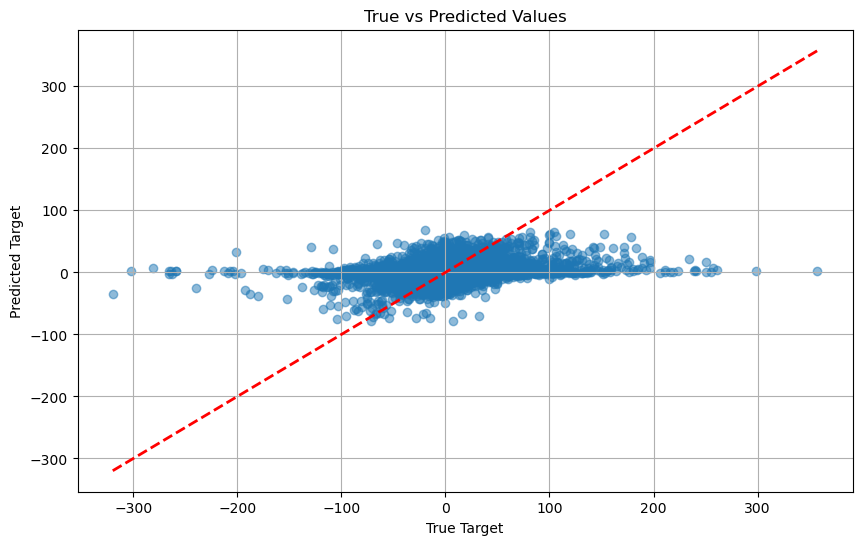

In [7]:
# Cell 6: (Optional) Evaluation on a Hold-Out Test Set & Visualization

# If you have a separate test set, load and scale it in the same way:
# (Assuming test_df is already defined and scaled as in Cell 2.)
test_ds = StockDataset(df, scale_cols, id_cols)  # or use a dedicated test_df
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# Load one of the best models (e.g., from fold 1) for evaluation:
model = CNN(input_dim=model_input_dim).to(device)
model.load_state_dict(torch.load('best_model_fold_1.pth'))
model.eval()

preds, targets = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        outputs = model(X)
        preds.append(outputs.cpu())
        targets.append(y)
preds = torch.cat(preds).numpy()
targets = torch.cat(targets).numpy()

print(f'Test MAE: {mean_absolute_error(targets, preds):.4f}')
print(f'Test R²: {r2_score(targets, preds):.4f}')

# Visualization: True vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(targets, preds, alpha=0.5)
plt.xlabel("True Target")
plt.ylabel("Predicted Target")
plt.title("True vs Predicted Values")
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
plt.grid(True)
plt.show()
